In [1]:
from scipy.optimize import minimize
from Truss_2D import Truss_2D
import numpy as np
from random import random
import matplotlib.pyplot as plt 

### Step 1: Initialize Design Variables

### Step 2.1: Define Model Analysis

In [2]:
def Truss_solver(cross_sectional_areas):
    nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
    elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
    supports = {5:[1,1], 6:[1,1]}
    forces = {2:[0,-100], 4:[0,-100]}
    elasticity = {key: 10_000 for key in elements}
    cross_area = {1:cross_sectional_areas[0], 2:cross_sectional_areas[1], 3:cross_sectional_areas[2], 4:cross_sectional_areas[3], 5:cross_sectional_areas[4],
                  6:cross_sectional_areas[5], 7:cross_sectional_areas[6], 8:cross_sectional_areas[7], 9:cross_sectional_areas[8], 10:cross_sectional_areas[9]}

    Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                    elements= elements,
                                    supports= supports,
                                    forces = forces,
                                    elasticity= elasticity,
                                    cross_area= cross_area)

    Ten_Bar_Truss_Case_1.Solve()

    return (Ten_Bar_Truss_Case_1.member_lengths_, Ten_Bar_Truss_Case_1.member_stresses_, Ten_Bar_Truss_Case_1.displacements_)

#### Step 2.2: Define Objective Function

In [3]:
def Objective_Function(areas):
    
    member_lengths, member_stresses, node_displacements = Truss_solver(areas)    
    total_area = np.array(areas)
    total_member_lengths = []
    
    for length in member_lengths:
        total_member_lengths.append(member_lengths[length])

    total_member_lengths = np.array(total_member_lengths)

    weight = total_area.dot(np.array(total_member_lengths))

    weight = weight.sum() * 0.1 # lb/in^3

    return (weight, member_stresses, node_displacements)

#### Step 2.3: Define Constraints

In [4]:
def stress_constraint(stress_new):
    if stress_new > 25 or stress_new < -25:
        stress_counter = 1
    else:
        stress_counter = 0
    
    return stress_counter

In [5]:
def displacement_constraint(node_displacement_new):    
    x = node_displacement_new[0]
    y = node_displacement_new[1]
    if x > 2 or x < -2:
        displacement_counter = 1
    elif y > 2 or y < -2:
        displacement_counter = 1
    else:
        displacement_counter = 0

    return displacement_counter

### Step 3: Define Algorithm

Step 3.1: Initialize Parameters

In [6]:
D = [1.62, 1.80, 1.99, 2.13, 2.38, 2.62, 2.63, 2.88, 2.93, 3.09,
     3.13, 3.38, 3.47, 3.55, 3.63, 3.84, 3.87, 3.88, 4.18, 4.22,
     4.49, 4.59, 4.80, 4.97, 5.12,5.74, 7.22, 7.97, 11.50, 13.50, 
     13.90, 14.20, 15.50, 16.00, 16.90, 18.80, 19.90, 22.00, 22.90, 
     26.50, 30.00, 33.50]

In [7]:
# area_old = np.random.choice(D,10)
area_old = np.array([30 for i in range(10)])
area_old

array([30, 30, 30, 30, 30, 30, 30, 30, 30, 30])

In [8]:
def closest(list_of_areas, area_values_list):
    for i, area_value in enumerate(area_values_list):
        idx = (np.abs(list_of_areas - area_value)).argmin() 
        area_values_list[i] = list_of_areas[idx]
    return area_values_list

In [9]:
# intermediate variables 
k = 1 # move variable's constant
M = 1000 # number of loops to be performed
T0 = 10000 # initial temperature
N = 20 # initial number of neighbors per search space loop
alpha = 0.85 # cooling parameter

In [10]:
temp = [] # storing of values for the temperature per loop M
min_weight = [] # storing best value of the objective function per loop M
area_list = [] # storing x values per loop for plotting purposes

Step 3.2: Simulated Annealing Algorithm

In [11]:
def Random_Number_Check(objective_old, objective_new, Init_temp):
    return 1/((np.exp(objective_old - objective_new)) / Init_temp)

In [12]:
%%time 
for m in range(M):
    for n in range(N):
        area_new = np.empty(10)
        for i,area in enumerate(area_old):
            random_area = random()
            if random_area >= 0.5:
                area_new[i] = k*random_area
            else:
                area_new[i] = -k*random_area 
        area_new = area_old + area_new
        closest(D,area_new)

        # area_new = np.random.choice(D,10)

        weight_computed, stresses_new, node_displacement_new = Objective_Function(area_new)
        weight_old, _, _ = Objective_Function(area_old)

        check = Random_Number_Check(weight_computed, weight_old, T0)
        random_number = random()

        # Contraint 1: stresses should be within 25ksi and -25ksi
        stress_counter = []
        for j in stresses_new:
            stress_counter.append(stress_constraint(stresses_new[j]))
        stress_counter = sum(stress_counter)

        # Constraint 2: Node Displacement should be limited to -2in and 2in
        displacement_counter = 0
        for k in node_displacement_new:
            displacement_counter = displacement_counter + displacement_constraint(node_displacement_new[k])

        if stress_counter >= 1 or displacement_counter >= 1:
            area_old = area_old
        else:        
            if weight_computed <= weight_old:
                area_old = area_new
            elif random_number <= check:
                area_old = area_new
            else:
                area_old = area_old

    temp.append(T0)
    min_weight.append(weight_old)
    area_list.append(area_old)
    
    T0 = alpha * T0

Wall time: 51.7 s


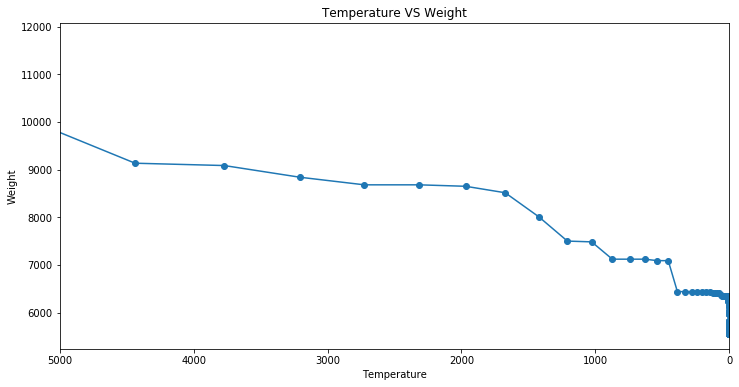

In [13]:
plt.figure(figsize=[12,6])
plt.xlim(5000,0)
plt.xlabel('Temperature')
plt.ylabel('Weight')
plt.title('Temperature VS Weight')
plt.plot(temp, min_weight, marker = 'o')

In [14]:
area_list[-1]

array([33.5 ,  1.62, 22.9 , 16.9 ,  1.62,  1.62,  5.74, 26.5 , 19.9 ,
        1.62])

In [15]:
nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
supports = {5:[1,1], 6:[1,1]}
forces = {2:[0,-100], 4:[0,-100]}
elasticity = {key: 10_000 for key in elements}
cross_area = {key+1: area_list[-1][key] for key in range(10)}

Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                elements= elements,
                                supports= supports,
                                forces = forces,
                                elasticity= elasticity,
                                cross_area= cross_area)

Ten_Bar_Truss_Case_1.Solve()

In [16]:
Ten_Bar_Truss_Case_1.displacements_

{1: [0.25149, -1.99181],
 2: [-0.4769, -1.99397],
 3: [0.24933, -0.75657],
 4: [-0.26408, -1.47013],
 5: [0.0, 0.0],
 6: [0.0, 0.0]}

In [17]:
Ten_Bar_Truss_Case_1.member_stresses_

{1: 6.92583,
 2: 0.06,
 3: -7.33556,
 4: -5.91167,
 5: 19.82111,
 6: 0.06,
 7: 16.75069,
 8: -7.045,
 9: 7.09958,
 10: -0.08486}

In [18]:
weight, _, _ = Objective_Function(area_list[-1])
weight

5550.772360074394